## Đồ Án Cuối Kỳ Nhập Môn Khoa Học Dữ Liệu

### Chủ đề: Dự đoán độ ẩm tương đối của ngày kế tiếp từ các thông số thời tiết khác như nhiệt độ, điểm sương, áp suất không khí, ... của ngày hiện tại và vài ngày trước

### Thông tin nhóm 11:
1. Nguyễn Văn Hậu - 18120359
2. Nguyễn Tấn Thìn - 18120085

### Nội dung file notebook:
1. Thu thập dữ liệu
2. Khám phá dữ liệu (để đưa ra câu hỏi)
3. Tách tập, tiền xử lý và khám phá dữ liệu
4. Tiền xử lý và mô hình hóa dữ liệu

## 1. Thu thập dữ liệu

#### Tổng quan về Visual Crossing Weather API
- Website: [`https://www.visualcrossing.com/weather-api`](https://www.visualcrossing.com/weather-api)
- Documents: [`https://www.visualcrossing.com/resources/documentation/weather-api/weather-api-documentation/#timeline`](https://www.visualcrossing.com/resources/documentation/weather-api/weather-api-documentation/#timeline)
- API cung cấp dữ liệu thời tiết gồm nhiệt độ, độ ẩm, áp suất, ... trong quá khứ giữa 2 khoảng thời gian cho trước tại một địa điểm xác định và có thể có thêm thông tin dự báo thời tiết (nhưng ta sẽ không lấy thông tin này
- Cần tạo một tài khoản để được cung cấp API key
- Mỗi API key miễn phí bị giới hạn chỉ được thu thập **tối đa 1000** kết quả trả về trong một ngày

#### Cú pháp API
`https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/[Location]/[Date1]/[Date2]?key=Your_API_Key`
với:
- `Location` là địa điểm cần lấy thông tin thời tiết
- `Date1` là thời gian bắt đầu
- `Date2` là thời gian kết thúc
- `Your_API_Key` là api key cung cấp cho mỗi tài khoản đăng kí

#### Cách thu thập data
- Chúng ta tiến hành thu thập dữ liệu thời tiết trong quá khứ theo từng ngày trong thời gian từ năm 2009 đến năm 2020, cụ thể là từ **1/1/2009** đến **31/12/2020**
- Vì giới hạn mỗi API key chỉ được thu thập **tối đa 1000** kết quả một ngày và số lượng API key có hạn nên nhóm em dùng 4 API key, mỗi API key tương ứng thu thập dữ liệu trong khoảng thời gian 2 năm. Nhóm em chia ra thu thập trong nhiều ngày. Phần code thu thập bên dưới chỉ nhằm mục đích minh họa chứ không thể chạy 1 lần trực tiếp lấy toàn bộ data như trong file .csv được.

### Import các thư viện

In [1]:
%matplotlib inline
import requests
import json
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import set_config
set_config(display='diagram') # Để trực quan hóa pipeline

### Chuẩn bị các hàm cần thiết

Hàm thu thập data giữa 2 ngày

In [2]:
def collect_data(start_date, end_date, api_key):
    url = f'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/Ho%20Chi%20Minh/{start_date}/{end_date}?unitGroup=metric&key={api_key}&include=obs'
    weather_data = []
    success = False
    while success == False:
        print(f"GET: {url}")
        r = requests.get(url)
        if r.ok == True:
            # lấy kết quả json
            pydata = json.loads(r.text)
            weather_data.extend(pydata["days"])
            print("Successful! Remaining cost:", pydata['remainingCost'])
            print()

            success = True
        else:
            print("Fail! Try again. Remaining cost:", pydata['remainingCost'])
            time.sleep(5)
        
    return weather_data

Hàm thu thập data giữa 2 năm

In [3]:
def collect_all_data(start_year, end_year, api_key):
    years = list(range(start_year, end_year + 1))
    print('List years:', years)
    month_days = [
        ((1, 1), (3, 31)), 
        ((4, 1), (6, 30)),
        ((7, 1), (9, 30)),
        ((10, 1), (12, 31))
    ]
    all_weather_data = []
    
    for year in years:
        for month_day in month_days:
            start_date = f'{year}-{month_day[0][0]}-{month_day[0][1]}'
            end_date = f'{year}-{month_day[1][0]}-{month_day[1][1]}'
            print(f'({start_date} -> {end_date})', end='\n')
#             print(url)
            weather_data = collect_data(start_date, end_date, api_key)
            all_weather_data.extend(weather_data)
        print()
        
    return all_weather_data

### Tiến hành thu thập data

Thu thập trong ngày 1

Thu thập trong ngày 2

In [1086]:
api_key1 = 'A29UZSNHSG8P8EPR6A4CM2UC6'
api_key2 = 'YXRHHRS6QX82D58S867TW6YBF'
api_key3 = '2DGMFZBTYTPJDTD7WLZQ58B8Z'
api_key4 = 'GKVCWLCJHBMBJHJYLCMQMXRV8'
all_weather_data = []

# Thu thập lần 1
start_year = 2009
end_year = 2010
# weather_data = collect_all_data(start_year, end_year, api_key1)
# all_weather_data.extend(weather_data)

# Thu thập lần 2
start_year = 2011
end_year = 2012
# weather_data = collect_all_data(start_year, end_year, api_key2)
# all_weather_data.extend(weather_data)

# print('Number of data:', len(all_weather_data))

Thu thập trong ngày 3

In [1087]:
api_key1 = 'A29UZSNHSG8P8EPR6A4CM2UC6'
api_key2 = 'YXRHHRS6QX82D58S867TW6YBF'
api_key3 = '2DGMFZBTYTPJDTD7WLZQ58B8Z'
api_key4 = 'GKVCWLCJHBMBJHJYLCMQMXRV8'
all_weather_data = []

# Thu thập lần 1
start_year = 2013
end_year = 2014
# weather_data = collect_all_data(start_year, end_year, api_key1)
# all_weather_data.extend(weather_data)

# Thu thập lần 2
start_year = 2015
end_year = 2016
# weather_data = collect_all_data(start_year, end_year, api_key2)
# all_weather_data.extend(weather_data)

# Thu thập lần 3
start_year = 2017
end_year = 2018
# weather_data = collect_all_data(start_year, end_year, api_key3)
# all_weather_data.extend(weather_data)

# Thu thập lần 4
start_year = 2019
end_year = 2020
# weather_data = collect_all_data(start_year, end_year, api_key4)
# all_weather_data.extend(weather_data)

# print('Number of data:', len(all_weather_data))

### Lưu data xuống file csv

Tạo dataframe và lưu dữ liệu xuống file `historical_weather_data.csv`

In [1088]:
# data_df = pd.DataFrame(all_weather_data)
# data_df.rename(lambda name: name[0].upper() + name[1:], axis='columns', inplace=True)
# data_df.to_csv('historical_weather_data.csv', index=False)
# data_df.head()

## 2. Khám phá dữ liệu (để đưa ra câu hỏi)

Dữ liệu thời tiết thu thập được ở bước trước là dữ liệu tại vị trí quận 1 của Thành phố Hồ Chí Minh.  

Load dữ liệu từ file `historical_weather_data.csv`. Dữ liệu gốc thu được từ API chứa khá nhiều cột không liên quan tới mục đích dự đoán, nên sẽ chỉ đọc ra một số cột quan trọng

In [4]:
selected_cols = ['Datetime', 'Tempmax', 'Tempmin', 'Temp', 'Feelslikemax', 'Feelslikemin', 'Feelslike', 'Dew', 'Humidity', 
                 'Precip', 'Precipcover', 'Windspeed', 'Winddir', 'Windgust', 'Pressure', 'Cloudcover', 'Visibility', 'Conditions', 'Icon']
data_df = pd.read_csv('historical_weather_data.csv')
data_df = data_df[selected_cols]
data_df.head()

,Datetime,Tempmax,Tempmin,Temp,Feelslikemax,Feelslikemin,Feelslike,Dew,Humidity,Precip,Precipcover,Windspeed,Winddir,Windgust,Pressure,Cloudcover,Visibility,Conditions,Icon
0,2009-01-01,31.1,22.1,25.6,34.7,22.1,26.8,22.9,86.50,0.5,4.17,13.0,269.4,NaN,1009.6,69.6,10.7,"Rain, Partially cloudy",cloudy
1,2009-01-02,29.7,22.1,25.3,31.4,22.1,26.0,20.5,76.42,0.0,0.00,16.6,107.9,NaN,1010.5,65.0,10.8,Partially cloudy,partly-cloudy-day
2,2009-01-03,28.4,21.1,24.7,30.2,21.1,25.2,20.1,76.12,0.0,0.00,11.2,156.3,NaN,1011.3,78.3,10.7,Overcast,cloudy
3,2009-01-04,29.7,21.1,24.5,32.4,21.1,25.3,20.5,79.16,0.0,0.00,9.4,270.6,NaN,1010.9,66.7,10.6,Partially cloudy,partly-cloudy-day
4,2009-01-05,31.1,21.1,25.9,33.8,21.1,27.0,22.0,80.76,0.0,0.00,14.8,174.4,NaN,1010.1,55.0,7.6,Partially cloudy,partly-cloudy-day


Xử lý thêm cột thông tin độ ẩm tương đối của ngày kế tiếp (HumidityFuture) (cột này dự tính sẽ là output của mô hình sắp xây dựng)

In [5]:
next_days = 1
humidity_future = [data_df.loc[i + next_days, 'Humidity'] for i in range(data_df.shape[0] - next_days)] + [None]*next_days
data_df['HumidityFuture'] = humidity_future
data_df.head()

,Datetime,Tempmax,Tempmin,Temp,Feelslikemax,Feelslikemin,Feelslike,Dew,Humidity,Precip,Precipcover,Windspeed,Winddir,Windgust,Pressure,Cloudcover,Visibility,Conditions,Icon,HumidityFuture
0,2009-01-01,31.1,22.1,25.6,34.7,22.1,26.8,22.9,86.50,0.5,4.17,13.0,269.4,NaN,1009.6,69.6,10.7,"Rain, Partially cloudy",cloudy,76.42
1,2009-01-02,29.7,22.1,25.3,31.4,22.1,26.0,20.5,76.42,0.0,0.00,16.6,107.9,NaN,1010.5,65.0,10.8,Partially cloudy,partly-cloudy-day,76.12
2,2009-01-03,28.4,21.1,24.7,30.2,21.1,25.2,20.1,76.12,0.0,0.00,11.2,156.3,NaN,1011.3,78.3,10.7,Overcast,cloudy,79.16
3,2009-01-04,29.7,21.1,24.5,32.4,21.1,25.3,20.5,79.16,0.0,0.00,9.4,270.6,NaN,1010.9,66.7,10.6,Partially cloudy,partly-cloudy-day,80.76
4,2009-01-05,31.1,21.1,25.9,33.8,21.1,27.0,22.0,80.76,0.0,0.00,14.8,174.4,NaN,1010.1,55.0,7.6,Partially cloudy,partly-cloudy-day,82.75


Xử lí thêm cột chứa thông tin thời tiết quá khứ của các ngày trước

In [6]:
max_prev_day = 8
prev_days = list(range(1, max_prev_day + 1))

for prev_day in prev_days:
    humidity_prev = [None]*prev_day + [data_df.loc[i - prev_day, 'Humidity'] for i in range(prev_day, data_df.shape[0])]
    col_name = f'HumidityPrev_{prev_day}'
    data_df[col_name] = humidity_prev
    
    temp_prev = [None]*prev_day + [data_df.loc[i - prev_day, 'Temp'] for i in range(prev_day, data_df.shape[0])]
    col_name = f'TempPrev_{prev_day}'
    data_df[col_name] = temp_prev
    
    temp_max_prev = [None]*prev_day + [data_df.loc[i - prev_day, 'Tempmax'] for i in range(prev_day, data_df.shape[0])]
    col_name = f'TempmaxPrev_{prev_day}'
    data_df[col_name] = temp_max_prev
    
    temp_min_prev = [None]*prev_day + [data_df.loc[i - prev_day, 'Tempmin'] for i in range(prev_day, data_df.shape[0])]
    col_name = f'TempminPrev_{prev_day}'
    data_df[col_name] = temp_min_prev
    
    dew_prev = [None]*prev_day + [data_df.loc[i - prev_day, 'Dew'] for i in range(prev_day, data_df.shape[0])]
    col_name = f'DewPrev_{prev_day}'
    data_df[col_name] = dew_prev
    
    press_prev = [None]*prev_day + [data_df.loc[i - prev_day, 'Pressure'] for i in range(prev_day, data_df.shape[0])]
    col_name = f'PressurePrev_{prev_day}'
    data_df[col_name] = press_prev

In [7]:
data_df.columns

Index(['Datetime', 'Tempmax', 'Tempmin', 'Temp', 'Feelslikemax',
       'Feelslikemin', 'Feelslike', 'Dew', 'Humidity', 'Precip', 'Precipcover',
       'Windspeed', 'Winddir', 'Windgust', 'Pressure', 'Cloudcover',
       'Visibility', 'Conditions', 'Icon', 'HumidityFuture', 'HumidityPrev_1',
       'TempPrev_1', 'TempmaxPrev_1', 'TempminPrev_1', 'DewPrev_1',
       'PressurePrev_1', 'HumidityPrev_2', 'TempPrev_2', 'TempmaxPrev_2',
       'TempminPrev_2', 'DewPrev_2', 'PressurePrev_2', 'HumidityPrev_3',
       'TempPrev_3', 'TempmaxPrev_3', 'TempminPrev_3', 'DewPrev_3',
       'PressurePrev_3', 'HumidityPrev_4', 'TempPrev_4', 'TempmaxPrev_4',
       'TempminPrev_4', 'DewPrev_4', 'PressurePrev_4', 'HumidityPrev_5',
       'TempPrev_5', 'TempmaxPrev_5', 'TempminPrev_5', 'DewPrev_5',
       'PressurePrev_5', 'HumidityPrev_6', 'TempPrev_6', 'TempmaxPrev_6',
       'TempminPrev_6', 'DewPrev_6', 'PressurePrev_6', 'HumidityPrev_7',
       'TempPrev_7', 'TempmaxPrev_7', 'TempminPrev_7', 'DewPre

In [8]:
data_df.head(5)

,Datetime,Tempmax,Tempmin,Temp,Feelslikemax,Feelslikemin,Feelslike,Dew,Humidity,Precip,...,TempmaxPrev_7,TempminPrev_7,DewPrev_7,PressurePrev_7,HumidityPrev_8,TempPrev_8,TempmaxPrev_8,TempminPrev_8,DewPrev_8,PressurePrev_8
0,2009-01-01,31.1,22.1,25.6,34.7,22.1,26.8,22.9,86.50,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-02,29.7,22.1,25.3,31.4,22.1,26.0,20.5,76.42,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-01-03,28.4,21.1,24.7,30.2,21.1,25.2,20.1,76.12,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-04,29.7,21.1,24.5,32.4,21.1,25.3,20.5,79.16,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-05,31.1,21.1,25.9,33.8,21.1,27.0,22.0,80.76,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Số dòng và số cột của dữ liệu

In [9]:
data_df.shape

(4383, 68)

### Ý nghĩa của mỗi dòng

Mỗi dòng là thông tin thời tiết ghi nhận được của một ngày trong năm, ngoài ra còn chứa thêm dữ liệu của vài ngày trước sau bước xử lí ở trên

### Ý nghĩa của mỗi cột

Ý nghĩa một số cột được ghi trong bảng sau:

|Cột|Ý nghĩa|Đơn vị đo|
|---|---|---|
|**Datetime**|Ngày (yyyy-m-d) ghi nhận thông tin| |
|**Tempmax**|Nhiệt độ cao nhất trong ngày|Celsius|
|**Tempmin**|Nhiệt độ thấp nhất trong ngày|Celsius|
|**Temp**|Nhiệt độ trung bình trong ngày|Celsius|
|**Dew**|Điểm sương, là nhiệt độ mà tại đó độ ẩm tương đối của khối không khí đạt 100% |Celsius|
|**Humidity**|Độ ẩm tương đối|%|
|**Precip**|Lượng mưa trong ngày|mm|
|**Precipcover**|Tỉ lệ thời gian mưa trong ngày|%|
|**Windspeed**|Tốc độ gió trung bình|kph|
|**Winddir**|Hướng gió đo so với hướng Bắc|Degrees|
|**Pressure**|Áp suất không khí|millibars|
|**Cloudcover**|Tỉ lệ mây bao phủ bầu trời|%|
|**Visibility**|Tầm nhìn xa ban ngày|km|
|**Conditions**|Hiện tượng thời tiết ghi nhận được như sấm sét, mưa, ...| |
|**Icon**|Thời tiết đại diện cho ngày| |
|**HumidityFuture**|Độ ẩm tương đối của ngày tiếp theo|%|
|**HumidityPrev_x**|Độ ẩm tương đối của x ngày trước|%|
|**TempPrev_x**|Nhiệt độ trung bình của x ngày trước|Celsius|
|**TempmaxPrev_x**|Nhiệt độ cao nhất của x ngày trước|Celsius|
|**TempminPrev_x**|Nhiệt độ thấp nhất của x ngày trước|Celsius|
|**DewPrev_x**|Điểm sương của x ngày trước|Celsius|
|**PressurePrev_x**|Áp suất không khí của x ngày trước|millibars|

Chi tiết cụ thể hơn về thông tin các cột có tại `https://www.visualcrossing.com/resources/documentation/weather-data/weather-data-documentation/`

### Kiểm tra các dòng có bị lặp không

In [10]:
data_df.index.duplicated().sum()

0

### Đưa ra câu hỏi

**Câu hỏi:** *Output* - độ ẩm tương đối của ngày mai (HumidityFuture) được tính từ *input* - các thông số khác (độ ẩm tương đối, nhiệt độ, điểm sương, áp suất, ...) của ngày hiện tại và vài ngày trước như thế nào?  
  
**Ý nghĩa:** Khi độ ẩm tương đối quá cao (> 90%) thì con người sẽ tăng nguy cơ mắc các bệnh khớp, ho, hen suyễn hay đau đầu, ngoài ra độ ẩm tương đối quá cao cũng là điều kiện cho các loại vi khuẩn và nấm mốc phát triển. Ngược lại, khi độ ẩm tương đối quá thấp (< 30%), con người dễ bị các triệu chứng như chảy máu cam hay bị virus cảm lạnh rhinovirus xâm nhập. Do đó, dự đoán được độ ẩm tương đối sẽ hữu ích trong việc đưa ra một số biện pháp như sử dụng máy điều khiển độ ẩm để tăng giảm độ ẩm, ... nhằm phòng ngừa các hậu quả xấu có thể xảy ra.

**Nguồn cảm hứng**: Từ thắc mắc về ý nghĩa của độ ẩm tương đối trong thực tiễn, nhóm đã tìm hiểu về độ ẩm tương đối thông qua nhiều nguồn khác nhau trên Internet và đưa ra bộ output - input trên với mong muốn dự đoán được độ ẩm của ngày kế tiếp.

## 3. Tách tập, tiền xử lí và khám phá dữ liệu

### Khám phá dữ liệu (để tách tập)

Kiểu dữ liệu của cột output

In [11]:
data_df['HumidityFuture'].dtype

dtype('float64')

Kiếm tra cột output có giá trị thiếu không

In [12]:
data_df['HumidityFuture'].isna().sum()

1

Xử lí xóa dòng có giá trị thiếu tại cột output

In [13]:
data_df = data_df.dropna(subset=['HumidityFuture'])
data_df.shape

(4382, 68)

Phân bố của cột output

In [14]:
humidity_fur_describe = data_df['HumidityFuture'].describe()
humidity_fur_describe

count    4382.000000
mean       77.485707
std         9.364456
min        49.530000
25%        71.240000
50%        78.115000
75%        84.497500
max        99.820000
Name: HumidityFuture, dtype: float64

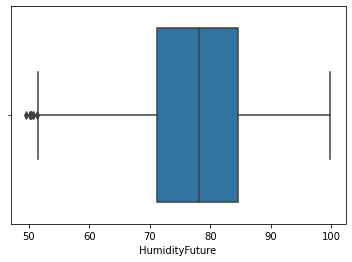

In [15]:
sns.boxplot(data_df['HumidityFuture']);

Khảo sát phân bố của cột thông tin lịch sử 1 ngày trước

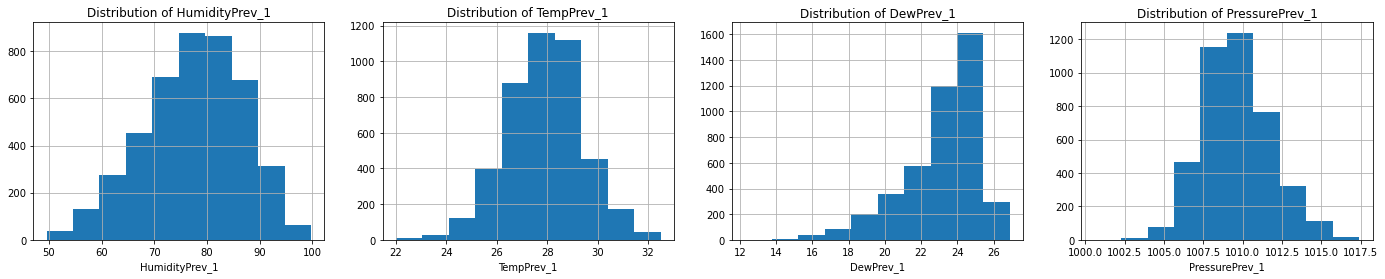

In [16]:
# plt.figure(figsize=(max_prev_day*4, 4))
# for i in range(1, max_prev_day+1):
#     plt.subplot(1, max_prev_day, i)
#     col_name = f'TempPrev_{i}'
#     data_df[col_name].hist()
#     plt.title(f'Distribution of {col_name}')
#     plt.xlabel(col_name)

plt.figure(figsize=(24, 4))

plt.subplot(1, 4, 1)
data_df['HumidityPrev_1'].hist()
plt.title('Distribution of HumidityPrev_1')
plt.xlabel('HumidityPrev_1')

plt.subplot(1, 4, 2)
data_df['TempPrev_1'].hist()
plt.title('Distribution of TempPrev_1')
plt.xlabel('TempPrev_1')

plt.subplot(1, 4, 3)
data_df['DewPrev_1'].hist()
plt.title('Distribution of DewPrev_1')
plt.xlabel('DewPrev_1')

plt.subplot(1, 4, 4)
data_df['PressurePrev_1'].hist()
plt.title('Distribution of PressurePrev_1')
plt.xlabel('PressurePrev_1')

plt.show()

### Tiền xử lí (tách các tập)

Tiến hành tách tập data thu được thành 3 tập huấn luyện, validation và tập kiểm tra theo tỉ lệ 70%-15%-15%

In [17]:
# Tách X_df và y_sr
y_sr = data_df["HumidityFuture"]
X_df = data_df.drop("HumidityFuture", axis = 1)

In [18]:
# Tách tập kiểm tra
train_valid_X_df, test_X_df, train_valid_y_sr, test_y_sr = train_test_split(
    X_df, y_sr, test_size = 0.15, random_state = 2)

In [19]:
# Tách tập validation, còn lại là của tập huấn luyện
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(
    train_valid_X_df, train_valid_y_sr, test_size = 3/17, random_state = 2)

Tập kiểm tra

In [20]:
test_X_df.shape

(658, 67)

Tập validation

In [21]:
val_X_df.shape

(658, 67)

Tập huấn luyện

In [22]:
train_X_df.shape

(3066, 67)

### Khám phá dữ liệu (tập huấn luyện)

#### Kiểu dữ liệu hiện tại của mỗi cột

In [23]:
train_X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3066 entries, 442 to 1147
Data columns (total 67 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Datetime        3066 non-null   object 
 1   Tempmax         3066 non-null   float64
 2   Tempmin         3066 non-null   float64
 3   Temp            3066 non-null   float64
 4   Feelslikemax    3066 non-null   float64
 5   Feelslikemin    3066 non-null   float64
 6   Feelslike       3061 non-null   float64
 7   Dew             3066 non-null   float64
 8   Humidity        3066 non-null   float64
 9   Precip          3066 non-null   float64
 10  Precipcover     3066 non-null   float64
 11  Windspeed       3066 non-null   float64
 12  Winddir         3066 non-null   float64
 13  Windgust        342 non-null    float64
 14  Pressure        2904 non-null   float64
 15  Cloudcover      3066 non-null   float64
 16  Visibility      3066 non-null   float64
 17  Conditions      3066 non-null  

Nhận xét: Phần lớn cột trong dữ liệu input là ở dạng số

#### Phân bố của các cột dữ liệu dạng số

In [24]:
num_cols = ['Tempmax', 'Tempmin', 'Temp', 'Feelslike', 'Dew', 'Humidity', 'Precip', 'Precipcover',
            'Windspeed', 'Winddir', 'Windgust', 'Pressure', 'Cloudcover', 'Visibility',
            'HumidityPrev_1', 'TempmaxPrev_1', 'TempminPrev_1', 'TempPrev_1', 'DewPrev_1', 'PressurePrev_1']
df = train_X_df[num_cols]

def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def lower_quartile(df):
    return df.quantile(0.25).round(1)
def median(df):
    return df.quantile(0.5).round(1)
def upper_quartile(df):
    return df.quantile(0.75).round(1)

df.agg([missing_ratio, 'min', lower_quartile, median, upper_quartile, 'max'])

,Tempmax,Tempmin,Temp,Feelslike,Dew,Humidity,Precip,Precipcover,Windspeed,Winddir,Windgust,Pressure,Cloudcover,Visibility,HumidityPrev_1,TempmaxPrev_1,TempminPrev_1,TempPrev_1,DewPrev_1,PressurePrev_1
missing_ratio,0.0,0.0,0.0,0.2,0.0,0.00,0.0,0.0,0.0,0.0,88.8,5.3,0.0,0.0,0.00,0.0,0.0,0.0,0.0,5.3
min,24.0,7.0,22.3,22.4,12.7,49.53,0.0,0.0,7.2,36.2,24.1,1000.6,7.2,5.7,49.53,24.0,7.0,22.1,12.3,1000.6
lower_quartile,31.9,23.1,26.9,28.5,22.2,71.50,0.0,0.0,15.8,139.3,35.3,1008.1,45.4,9.3,71.30,31.9,23.1,26.9,22.2,1008.1
median,33.0,24.1,27.9,30.3,23.7,78.30,0.0,0.0,18.4,184.4,40.7,1009.4,54.7,9.9,78.30,33.0,24.3,27.9,23.7,1009.4
upper_quartile,34.0,25.6,28.8,32.1,24.6,84.50,2.0,4.2,22.3,233.2,48.2,1011.0,66.5,10.3,84.50,34.0,25.6,28.8,24.6,1011.0
max,38.1,29.9,32.5,39.2,26.9,99.82,151.1,37.5,74.2,343.3,77.8,1017.4,99.6,76.6,99.82,38.1,29.9,32.5,26.8,1017.4


#### Phân bố của các cột dữ liệu không phải dạng số

In [25]:
pd.set_option('display.max_colwidth', 200) # Để nhìn rõ hơn
cat_cols = ['Datetime', 'Conditions', 'Icon']
cat_multi_cols = ['Conditions']
df = train_X_df[cat_cols]

def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def num_values(df):
    return df.nunique()
def value_ratios(c):
    if c.name in cat_multi_cols:
        s = c.str.split(', ').explode().value_counts(normalize=True)
        return dict((s * 100).round(1))
    else:
        return dict((c.value_counts(normalize=True) * 100).round(1))
    
df.agg([missing_ratio, num_values, value_ratios])

,Datetime,Conditions,Icon
missing_ratio,0,0,0
num_values,3066,5,5
value_ratios,"{'2010-05-09': 0.0, '2013-03-17': 0.0, '2012-01-01': 0.0, '2009-09-18': 0.0, '2010-08-28': 0.0, '2012-01-16': 0.0, '2014-05-26': 0.0, '2017-09-02': 0.0, '2015-03-02': 0.0, '2018-10-15': 0.0, '2016...","{'Partially cloudy': 62.0, 'Rain': 26.9, 'Overcast': 10.0, 'Clear': 1.0}","{'partly-cloudy-day': 57.7, 'rain': 29.0, 'cloudy': 10.4, 'clear-day': 1.4, 'wind': 1.4}"


## 4. Tiền xử lí và mô hình hóa dữ liệu

### Tiền xử lí tập huấn luyện

Đầu tiên, class ColAdderDropper xử lí thêm bớt một số cột như sau:
- Tạo thêm Month lấy thông tin tháng từ cột Datetime. Sau đó bỏ cột Datetime.
- Bỏ các cột Feelslikemax, Feelslikemin, Feelslike, Precip, Precipcover, Winddir, Cloudcover, Visibility, Conditions, Icon vì có lẽ các cột này không mang lại nhiều thông tin hữu ích.
- Bỏ cột Windgust vì chứa nhiều giá trị rỗng (NaN)

Với các cột dữ liệu dạng số ta sẽ điền giá trị thiếu bằng mean của cột bằng cách sử dụng `SimpleImputer`

In [26]:
class ColAdderDropper(BaseEstimator, TransformerMixin):
    def __init__(self, num_prev_day=1):
        # num_prev_day thuộc khoảng [1, 5]
        if num_prev_day < 1:
            num_prev_day = 1
        elif num_prev_day > max_prev_day:
            num_prev_day = max_prev_day
        self.num_prev_day = num_prev_day
    def fit(self, X_df, y = None):
        return self
    def transform(self, X_df, y = None):
        # YOUR CODE HERE
        # Thêm cột
        df = X_df.copy()
        month_sr = df['Datetime'].str.split('-').apply(lambda x: x[1])
        day_sr = df['Datetime'].str.split('-').apply(lambda x: x[2])
#         df.insert(0, 'Day', day_sr)
        df.insert(0, 'Month', month_sr)
    
        # Xóa các cột không cần thiết
        drop_cols = ['Datetime', 'Feelslikemax', 'Feelslikemin', 'Feelslike', 'Precip', 'Precipcover',
                     'Winddir', 'Windgust', 'Cloudcover', 'Visibility', 'Conditions', 'Icon']
        df.drop(drop_cols, axis = 1, inplace = True)
        
        # Xử lí xóa các cột HumidityPrev, TempPrev
        drop_cols = []
        drop_cols = [f'HumidityPrev_{i}' for i in range(self.num_prev_day + 1, max_prev_day+1)]
        drop_cols.extend([f'TempPrev_{i}' for i in range(self.num_prev_day + 1, max_prev_day+1)])
        drop_cols.extend([f'TempmaxPrev_{i}' for i in range(self.num_prev_day + 1, max_prev_day+1)])
        drop_cols.extend([f'TempminPrev_{i}' for i in range(self.num_prev_day + 1, max_prev_day+1)])
        drop_cols.extend([f'DewPrev_{i}' for i in range(self.num_prev_day + 1, max_prev_day+1)])
        drop_cols.extend([f'PressurePrev_{i}' for i in range(self.num_prev_day + 1, max_prev_day+1)])
        df.drop(drop_cols, axis = 1, inplace = True)
        return df

In [27]:
# TEST
col_adderdropper = ColAdderDropper(num_prev_day=3)
fewer_cols_train_X_df = col_adderdropper.fit_transform(train_X_df)
fewer_cols_train_X_df.head()

,Month,Tempmax,Tempmin,Temp,Dew,Humidity,Windspeed,Pressure,HumidityPrev_1,TempPrev_1,...,TempmaxPrev_2,TempminPrev_2,DewPrev_2,PressurePrev_2,HumidityPrev_3,TempPrev_3,TempmaxPrev_3,TempminPrev_3,DewPrev_3,PressurePrev_3
442,03,36.0,21.1,28.9,19.2,58.02,19.6,1011.2,55.14,29.3,...,35.7,23.0,19.2,1013.0,54.56,30.2,36.4,25.9,19.1,1011.7
966,08,32.0,24.0,26.7,24.0,85.98,24.1,1006.1,84.26,26.7,...,32.0,22.1,23.8,1007.7,86.18,27.0,33.0,24.0,24.2,1008.5
1992,06,29.2,24.0,26.4,25.9,96.98,23.9,1007.8,85.49,27.5,...,31.0,23.0,25.0,1008.4,92.18,27.3,32.4,24.0,25.7,1006.0
2743,07,31.0,24.0,27.7,23.9,80.55,24.1,1008.1,75.11,28.2,...,35.0,24.0,25.0,1008.7,76.00,29.4,34.0,25.0,24.3,1010.7
1739,10,29.1,24.1,25.1,24.4,96.57,16.6,1008.8,92.48,25.7,...,31.1,24.1,24.0,1008.9,91.07,26.2,29.2,25.2,24.6,1009.6


Đến đây, dữ liệu hiện chỉ có các cột dạng số (numerical) (vì các cột không có dạng số đã bị loại bỏ vì không hữu ích) gồm: "Month", "Tempmax", "Tempmin", "Temp", "Dew", "Humidity", "Windspeed", "Pressure", "HumidityPrev_x", "TempmaxPrev_x", "TempminPrev_x", "TempPrev_x", "DewPrev_x", "PressurePrev_x". Các bước tiền xử lý tiếp theo như sau:
- Ta sẽ điền giá trị thiếu cho các cột dạng số bằng giá trị mean của cột. Với *tất cả* các cột dạng số trong tập huấn luyện, ta đều cần tính mean, vì ta không biết được cột nào sẽ bị thiếu giá trị khi dự đoán với các véc-tơ input mới. 
- Cuối cùng, khi tất cả các cột đã được điền giá trị thiếu và đã có dạng số, ta sẽ tiến hành chuẩn hóa bằng cách trừ đi mean và chia cho độ lệch chuẩn của cột để giúp cho các thuật toán cực tiểu hóa như Gradient Descent, LBFGS, ... hội tụ nhanh hơn.

In [28]:
nume_cols = ['Month', 'Tempmax', 'Tempmin', 'Temp', 'Dew', 'Humidity',
             'Windspeed', 'Pressure']

# unorder_cate_cols = ['Icon']

# unorder_cate_pipeline = make_pipeline(
#     SimpleImputer(missing_values = np.nan, strategy = 'most_frequent'),
#     OneHotEncoder(handle_unknown = "ignore")
# )

# col_transform = make_column_transformer(
#     (SimpleImputer(strategy='mean'), nume_cols),
#     (unorder_cate_pipeline, unorder_cate_cols),
#     remainder='passthrough'
# )

preprocess_pipeline = make_pipeline(
    ColAdderDropper(num_prev_day=3),
#     col_transform,
    SimpleImputer(strategy='mean'),
    StandardScaler()
)
preprocessed_train_X = preprocess_pipeline.fit_transform(train_X_df)
#TEST
preprocess_pipeline

Pipeline(steps=[('coladderdropper', ColAdderDropper(num_prev_day=3)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

### Tiền xử lí tập validation

In [29]:
preprocessed_val_X = preprocess_pipeline.transform(val_X_df)

### Kết hợp tiền xử lí và mô hình hóa

Ta sẽ sử dụng mô hình Neural Net để phân lớp. Ta tạo ra một pipeline từ đầu đến cuối bao gồm: các bước tiền xử lý ở trên + Neural Net  

Sau khi đã có được pipeline từ đầu đến cuối này, ta sẽ thử nghiệm:
- Siêu tham số `alpha` (mức độ L2 regularization hay weight decay) của `MLPRegressor` với 5 giá trị khác nhau: 0.01 0.1, 1, 10, 100, 1000.
- Siêu tham số `num_prev_day`: số ngày trong quá khứ mà ta dùng dữ liệu thời tiết của các ngày đó, với các giá trị: 1, 2, 3, 4, 5, 6, 7, 8

Như vậy, ta sẽ thử nghiệm nhiều mô hình khác nhau, với mỗi mô hình ta sẽ: huấn luyện trên tập huấn luyện, tính độ lỗi trên tập huấn luyện và tập validation rồi `append` độ lỗi vào 2 list tương ứng là `train_errs` và `var_errs` (để dễ nhìn, ta tính độ lỗi theo đơn vị %, nghĩa là có giá trị từ 0-100). Sau đó lưu lại độ lỗi nhỏ nhất trên tập validation, giá trị `alpha` và `num_prev_day` tương ứng lần lượt vào biến `best_val_err`, `best_alpha` và `best_num_prev_day`

In [30]:
# Tạo full_pipeline
full_pipeline = make_pipeline(
    preprocess_pipeline,
#     MLPRegressor(hidden_layer_sizes = (30), activation = 'tanh', solver = 'lbfgs', random_state = 0, max_iter = 6000)
#     MLPRegressor(hidden_layer_sizes = (80, 40), activation = 'relu', solver = 'adam', random_state = 0, max_iter = 6000)
    MLPRegressor(hidden_layer_sizes = (20, 20), activation = 'relu', solver = 'adam', random_state = 0, max_iter = 6000)
)

# Thử nghiệm với nhiều giá trị khác nhau của siêu tham số
#mlpregressor__alpha, mlpregressor__max_iter, mlpregressor__hidden_layer_sizes
train_errs = []
val_errs = []
# alphas = [0.01, 0.1, 1.0, 10, 100, 1000]
alphas = [0.01, 0.1, 1.0, 10, 100]
num_prev_days = list(range(1, max_prev_day + 1))
best_val_err = float('inf'); best_alpha = None; best_num_prev_day = None

for alpha in alphas:
    for num_prev_day in num_prev_days:
        # Chọn siêu tham số và huấn luyện
        full_pipeline.set_params(mlpregressor__alpha = alpha, pipeline__coladderdropper__num_prev_day=num_prev_day)
        print(f'Training - Apha: {alpha} - Num_Prev_Day: {num_prev_day}', end=' - ')
        full_pipeline.fit(train_X_df, train_y_sr)

        # Đánh giá
        train_err = ((1 - full_pipeline.score(train_X_df, train_y_sr)) * 100).round(3)
        train_errs.append(train_err)
        val_err = ((1 - full_pipeline.score(val_X_df, val_y_sr)) * 100).round(3)
        val_errs.append(val_err)
        
        print(f'Train_err: {train_err} - Val_err: {val_err}')

        # Lưu thông tin mô hình tốt nhất
        if val_err < best_val_err:
            best_val_err = val_err
            best_alpha = alpha
            best_num_prev_day = num_prev_day
'Finish!'

Training - Apha: 0.01 - Num_Prev_Day: 1 - Train_err: 25.052 - Val_err: 26.769
Training - Apha: 0.01 - Num_Prev_Day: 2 - Train_err: 24.791 - Val_err: 26.79
Training - Apha: 0.01 - Num_Prev_Day: 3 - Train_err: 23.373 - Val_err: 27.012
Training - Apha: 0.01 - Num_Prev_Day: 4 - Train_err: 24.063 - Val_err: 26.274
Training - Apha: 0.01 - Num_Prev_Day: 5 - Train_err: 22.929 - Val_err: 28.263
Training - Apha: 0.01 - Num_Prev_Day: 6 - Train_err: 21.012 - Val_err: 27.744
Training - Apha: 0.01 - Num_Prev_Day: 7 - Train_err: 22.673 - Val_err: 29.169
Training - Apha: 0.01 - Num_Prev_Day: 8 - Train_err: 21.332 - Val_err: 29.37
Training - Apha: 0.1 - Num_Prev_Day: 1 - Train_err: 24.544 - Val_err: 26.548
Training - Apha: 0.1 - Num_Prev_Day: 2 - Train_err: 24.566 - Val_err: 26.947
Training - Apha: 0.1 - Num_Prev_Day: 3 - Train_err: 22.855 - Val_err: 26.4
Training - Apha: 0.1 - Num_Prev_Day: 4 - Train_err: 24.173 - Val_err: 25.941
Training - Apha: 0.1 - Num_Prev_Day: 5 - Train_err: 22.95 - Val_err: 28.

'Finish!'

In [31]:
# Test
full_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('coladderdropper',
                                  ColAdderDropper(num_prev_day=8)),
                                 ('simpleimputer', SimpleImputer()),
                                 ('standardscaler', StandardScaler())])),
                ('mlpregressor',
                 MLPRegressor(alpha=100, hidden_layer_sizes=(20, 20),
                              max_iter=6000, random_state=0))])

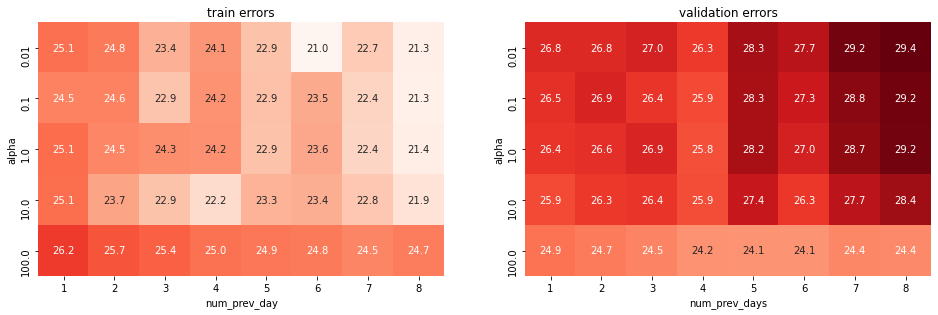

In [32]:
# Trực quan hóa kết quả
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(alphas), -1),
                             index=alphas, columns=num_prev_days)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(alphas), -1), 
                           index=alphas, columns=num_prev_days)

min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('train errors'); plt.xlabel('num_prev_day'); plt.ylabel('alpha')

plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('validation errors'); plt.xlabel('num_prev_days'); plt.ylabel('alpha');

Nhận xét: Ở các giá trị siêu tham số làm độ lỗi trên tập huấn luyện thấp thì độ lỗi ở tập huấn luyện lại cao. Có thể là dấu hiệu của overfitting do kích thước dữ liệu không lớn.

#### Huấn luyện lại mô hình với kết quả siêu tham số tốt nhất

In [33]:
best_alpha

100

In [34]:
best_num_prev_day

6

In [35]:
full_pipeline.set_params(mlpregressor__alpha = best_alpha, pipeline__coladderdropper__num_prev_day=best_num_prev_day)
full_pipeline.fit(train_valid_X_df, train_valid_y_sr)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('coladderdropper',
                                  ColAdderDropper(num_prev_day=6)),
                                 ('simpleimputer', SimpleImputer()),
                                 ('standardscaler', StandardScaler())])),
                ('mlpregressor',
                 MLPRegressor(alpha=100, hidden_layer_sizes=(20, 20),
                              max_iter=6000, random_state=0))])

### Đánh giá mô hình tìm được

**Độ lỗi trên tập kiểm tra**

In [36]:
((1 - full_pipeline.score(test_X_df, test_y_sr))*100).round(1)

22.9